# Quality Report - FORCE Met Tower dataset

## Introduction
This is a brief version of the force_qualitychecks.ipynb file, for practical quality monitoring of data. To keep it brief, there are fewer explanations and more flexibility in terms of configurating and monitoring the notebook.





# CODE PANEL 1 : Configure the Notebook

## Instructions

The following panel will contain the main parameters for manipulating the notebook for QA / Qartod purposes. The default will use Qartod recommended values as per the Qartod manual. Once you have checked and modified these parameters, you should use the "Run All" feature of Jupyter notebooks to run all of the windows and see an updated quality check.

For most use cases, this should be the only panel you need to alter. For a new dataset, you should:

- Copy this Jupyter notebook into the desired folder
- Change `DATASET_ID` to match the associated id / name for the dataset you want to perform Quality Assurance tests on
- Include the column names that correspond to the data included in ERDDAP in `column_names`
- Include any columns you would like excluded from dataframe outputs (for usability) in `excluded`.
- Include the conversion types om `types` (This assures you will not meet errors later on and may be automated in future).
- Change the path of YAML_CONFIG_FILE to a properly qartod formatted Config.  An [example is provided](./qa_sample.yml).
- If you have more complex tests (e.g. cross-referencing tables, or binning) use 
- Use `Run All` to launch the tests 

In [252]:
##
##  CODE PANEL 1 : Configure the Notebook

## You can change these variables and "run all" to reset the notebook.

# The id corresponding to the dataset to be tested.
# A complete list of dataset names is available at https://cioosatlantic.ca/erddap/info/index.html.
# In the Dataset ID column.
DATASET_ID = "force_meteorological_tower"

# A YAML file containing relevant QA parameters for the tests that will be conducted
YAML_CONFIG_FILE = "qa_sample.yml"

# The server to collect the d
ERDDAP_SERVER = "https://cioosatlantic.ca/erddap/"

# A list of names to be used as columns in the dataframes.
column_names = ['StationID', 'time', 'longitude', 'latitude', 'battery_voltage',
       'air_temperature', 'solar_irradiance', 'relative_humidity', 'Manual_BP',
       'wind_speed', 'air_potential_temperature', 'wind_speed_15min_max',
       'Prog_Sig', 'air_pressure', 'solar_irradiance_raw',
       'wind_speed_2min_max', 'air_pressure_raw', 'Rain_mm',
       'wind_from_direction_15min_average', 'air_temperature_1min_max',
       'wind_from_direction', 'wind_speed_15min_median',
       'wind_speed_15min_average', 'Elevation_Correction', 'elevation']


# A list of values from `column_names` to exclude from dataframe views etc.
exclude = ['StationID', 'battery_voltage', ]

# A dictionary of datatypes to enforce type safety of data.
types = {
       'StationID':int, 'time':str, 'longitude':float, 
       'latitude':float, 'battery_voltage':float, 'air_temperature':float, 
       'solar_irradiance':float, 'relative_humidity':float, 'Manual_BP':int,
       'wind_speed':float, 'air_potential_temperature':float, 'wind_speed_15min_max':float, 
       'Prog_Sig':int, 'air_pressure':float, 'solar_irradiance_raw':float,
       'wind_speed_2min_max':float, 'air_pressure_raw':float, 'Rain_mm':float,
       'wind_from_direction_15min_average':float, 'air_temperature_1min_max':float, 'wind_from_direction':float, 
       'wind_speed_15min_median':float, 'wind_speed_15min_average':float
       }


In [253]:
# CODE PANEL 2 - Basic Data imports - additional imports for qartod are available below

# Data manipulation utilities

import pandas as pd
import datetime as dt
from datetime import datetime
import netCDF4 as nc
import yaml

# ERDDAP specific tools.
from erddapy import ERDDAP
import erddapy

# Quality control libraries

try: 
    from ioos_qc.config import Config
except: 
    from ioos_qc.config import QcConfig

from ioos_qc.streams import PandasStream
from ioos_qc import qartod
from ioos_qc import utils
from ioos_qc.stores import PandasStore
from ioos_qc.results import collect_results

# Visualization Tools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Http requests and helpers

import requests
import httpx
# Running this notebook in a Windows conda environment eventually ran into some expired cross-signed SSL certificate issues
# The current work-around is to use the WSL2 environment as it properly uses the Windows certificates
# https://www.reddit.com/r/learnpython/comments/q5fffb/windows_python_397_urllib_and_dst_root_ca_x3_lets/
import urllib.request
import certifi
# https://stackoverflow.com/questions/24374400/verifying-https-certificates-with-urllib-request
# https://docs.python.org/3/library/ssl.html
import ssl
from requests.utils import DEFAULT_CA_BUNDLE_PATH; print(DEFAULT_CA_BUNDLE_PATH)



/Users/ryandeschamps/opt/anaconda3/envs/quality/lib/python3.10/site-packages/certifi/cacert.pem


In [254]:
## CODE PANEL 3 - Helper functions

## TODO - it may be nicer to have a library of helper functions included in the project.


def matplotlib_results(df, results, title):
    """ Plot timeseries of original data colored by quality flag

    Args:
        data: pd.DataFrame of original data including a time variable
        var_name: string name of the variable to plot
        results: Ordered Dictionary of qartod test results
        title: string to add to plot title
        test_name: name of the test to determine which flags to use
    """
    # Set-up
    time = df['time']
    obs = results.data
    qc_test = results.results

    # Create a separate timeseries of each flag value
    qc_pass = np.ma.masked_where(qc_test != 1, obs)
    qc_suspect = np.ma.masked_where(qc_test != 3, obs)
    qc_fail = np.ma.masked_where(qc_test != 4, obs)
    qc_notrun = np.ma.masked_where(qc_test != 2, obs)
    qc_missing = np.ma.masked_where(qc_test != 9, obs)

    # start the figure
    plt.figure(figsize=(25,10))
    plt.grid.grid_line_alpha=0.3
    plt.title(title)
    #plt.xlabel('Time')
    #plt.ylabel('Observation Value')


    # plot the data, and the data colored by flag
    plt.plot(time, obs, linestyle='', color='#A6CEE3')
    plt.plot(time, qc_notrun, label='qc not run', color='gray', marker='o', alpha=0.2)
    plt.plot(time, qc_pass, label='qc pass', color='green', marker='o', alpha=0.5)
    plt.plot(time, qc_suspect, label='qc suspect', color='orange', marker='o', alpha=0.7)
    plt.plot(time, qc_fail, label='qc fail', color='red', marker='o', alpha=1.0)
    plt.plot(time, qc_missing, label='qc missing', color='blue', marker='o', alpha=1.0)
    plt.legend()
    # show the plot
    plt.show()

def get_erddap_data():
    e = ERDDAP(server=ERDDAP_SERVER)
    e.protocol = "tabledap"
    e.dataset_id = DATASET_ID if DATASET_ID == "" else "force_meteorological_tower"
    e.response = "csv"
    url = e.get_download_url()
    df_csv = pd.read_csv(url, dtype=types, header=0, skiprows=2, names=column_names, parse_dates=['time'])
    return df_csv



In [255]:
## CODE PANEL 4 - Load the data into ERDDAP

# Creating the erddapy object and downloading a fresh CSV file from ERDDAP into a dataframe
df_csv = get_erddap_data()

# This method is useful for running the baseline ioos_qc tests all at once. Requires some setup.
# df1 = e.to_xarray()
# print(df1)

# This step is needed in confirming the datatypes and properly loading data into the pandas dataframe.
# df_csv.dtypes
df_csv.head()


,StationID,time,longitude,latitude,battery_voltage,air_temperature,solar_irradiance,relative_humidity,Manual_BP,wind_speed,...,wind_speed_2min_max,air_pressure_raw,Rain_mm,wind_from_direction_15min_average,air_temperature_1min_max,wind_from_direction,wind_speed_15min_median,wind_speed_15min_average,Elevation_Correction,elevation
0,1156,2016-12-09 14:19:23+00:00,-64.403,45.3713,13.24182,-0.990490,0.104737,74.01630,0,3.8416,...,4.900,1000.1650,0.0,NaN,-0.990,282.2419,NaN,NaN,1.80078,25.0
1,1156,2016-12-09 14:34:23+00:00,-64.403,45.3713,13.24734,-1.024410,0.271738,70.96338,0,6.2132,...,6.390,1000.1650,0.0,NaN,-0.990,305.6517,NaN,NaN,1.80078,25.0
2,1156,2016-12-09 14:49:23+00:00,-64.403,45.3713,13.23076,-0.854805,0.195477,68.82634,0,3.4496,...,10.190,1000.1650,0.0,NaN,-0.685,319.5723,NaN,NaN,1.80078,25.0
3,1156,2016-12-09 15:04:23+00:00,-64.403,45.3713,13.21419,-0.617355,0.218138,69.40301,0,7.3892,...,9.330,999.9866,0.0,NaN,-0.448,300.2328,NaN,NaN,1.80078,25.0
4,1156,2016-12-09 15:19:23+00:00,-64.403,45.3713,13.21419,-0.922649,0.142361,70.01358,0,7.2324,...,6.468,999.9866,0.0,NaN,-0.719,303.0988,NaN,NaN,1.80078,25.0


# Additional Data Modifications

It is possible that a dataset may benefit from cross-referencing or other manipulations that can also be tested. For example, a relative humidity value may be tested against the air temperature reading, or perhaps the data can be run through a previously trained model. 

Such calculations can be included in the dataframe in the panel below. If you wish to test these readings, you must include them as a variable in the qa.yml configuration file.

In [256]:
## CODE PANEL 5 - Perform any cross-relational functions

# Cross-variable additions and modifications
# If we require some massaging of data before we run the tests, we can place it here.

## Basic binning of air temperature as an example
bins = [-50, -25, 0, 25, 50]
labels = ["freezing", "cold", "warm", "hot"]
df_csv['air_temp_binned'] = pd.cut(df_csv['air_temperature'], bins=bins, labels=labels)

## Modify values based on seasonality

## TODO - adapt temperature to account for seasonality somehow


## QARTOD QC Testing
### Note:
We ran the qartod qc library on this dataset to check for any out of range values, such as high wind speeds or air temperature outliers, and missing data that has either a datetime, or missing a single 15-minute time chunk.

The qartod manuals require running several tests (if and as they apply to each dataset variable), and initially we include one recommended spike test.

Set up the configuration object for the qartod wind speed gross range and spike tests, and run the tests as an example of what the raw qc flags look like.

In [257]:
# Load qartod yaml file
import yaml

with open(YAML_CONFIG_FILE) as stream:
    try:
        yaml_config = Config(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:

# All variables mentioned in the configuration should be evaluated.

ps = PandasStream(df_csv)
results = collect_results(ps.run(yaml_config), 'list')

wind_speed_with_na is not a column in the dataframe, skipping
wind_speed_with_na not a column in the input dataframe, skipping


In [ ]:
from collections import Counter

count = {}
## Raw results

for test in results: 
    print ("Results for " + test.stream_id)
    count = Counter(test.results)
    count['passed'] = count.pop(1) if 1 in count.keys() else None
    count['didnotrun'] = count.pop(2) if 2 in count.keys() else None
    count['suspect'] = count.pop(3) if 3 in count.keys() else None
    count['failed'] = count.pop(4) if 4 in count.keys() else None
    count['missing'] = count.pop(9) if 9 in count.keys() else None
    print(f"Passed: {count['passed']}\nSuspect: {count['suspect']}\nFailed: {count['failed']}\nDid Not Run: {count['didnotrun']}\nMissing: {count['missing']}\n\n\n")

Results for wind_speed
Passed: 195833
Suspect: 146
Failed: None
Did Not Run: None
Missing: None



Results for air_temperature
Passed: 195979
Suspect: None
Failed: None
Did Not Run: None
Missing: None



Results for air_potential_temperature
Passed: 195979
Suspect: None
Failed: None
Did Not Run: None
Missing: None



Results for solar_irradiance
Passed: 194266
Suspect: 1305
Failed: 408
Did Not Run: None
Missing: None



Results for relative_humidity
Passed: 138149
Suspect: 57368
Failed: 462
Did Not Run: None
Missing: None





[1 1 1 ... 1 1 1]
[3.8416   6.2132   3.4496   ... 8.8984   9.819599 7.271599]


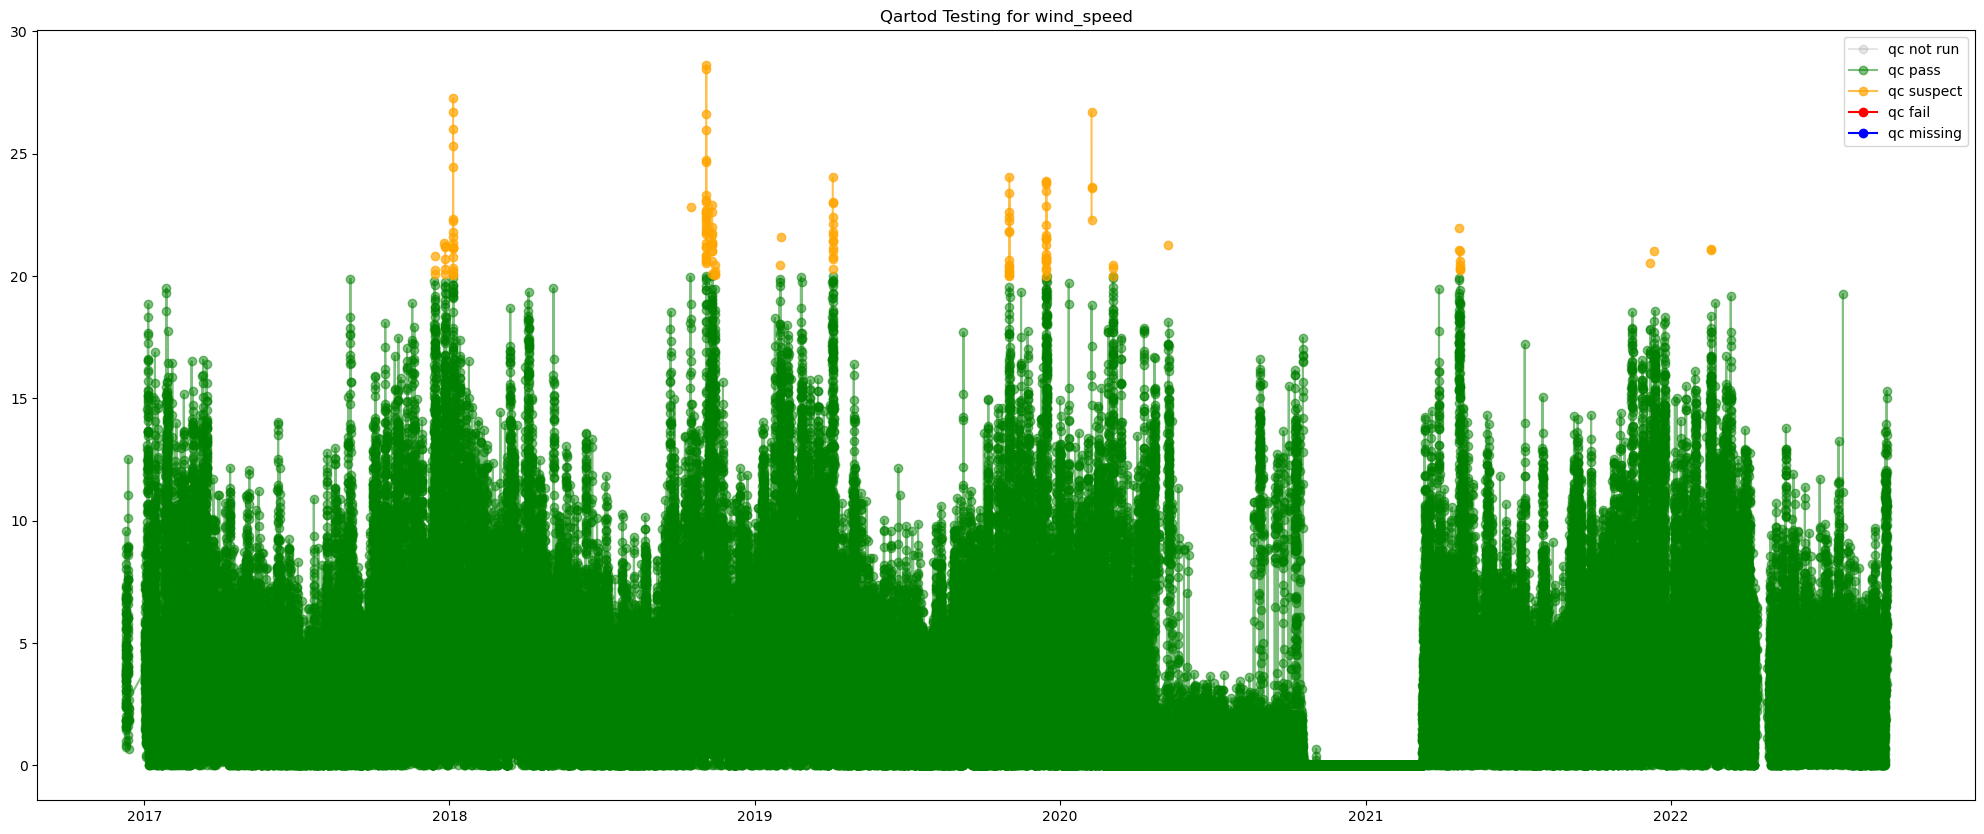

[1 1 1 ... 1 1 1]
[-0.9904899 -1.02441   -0.854805  ... 12.66391   12.69412   13.11933  ]


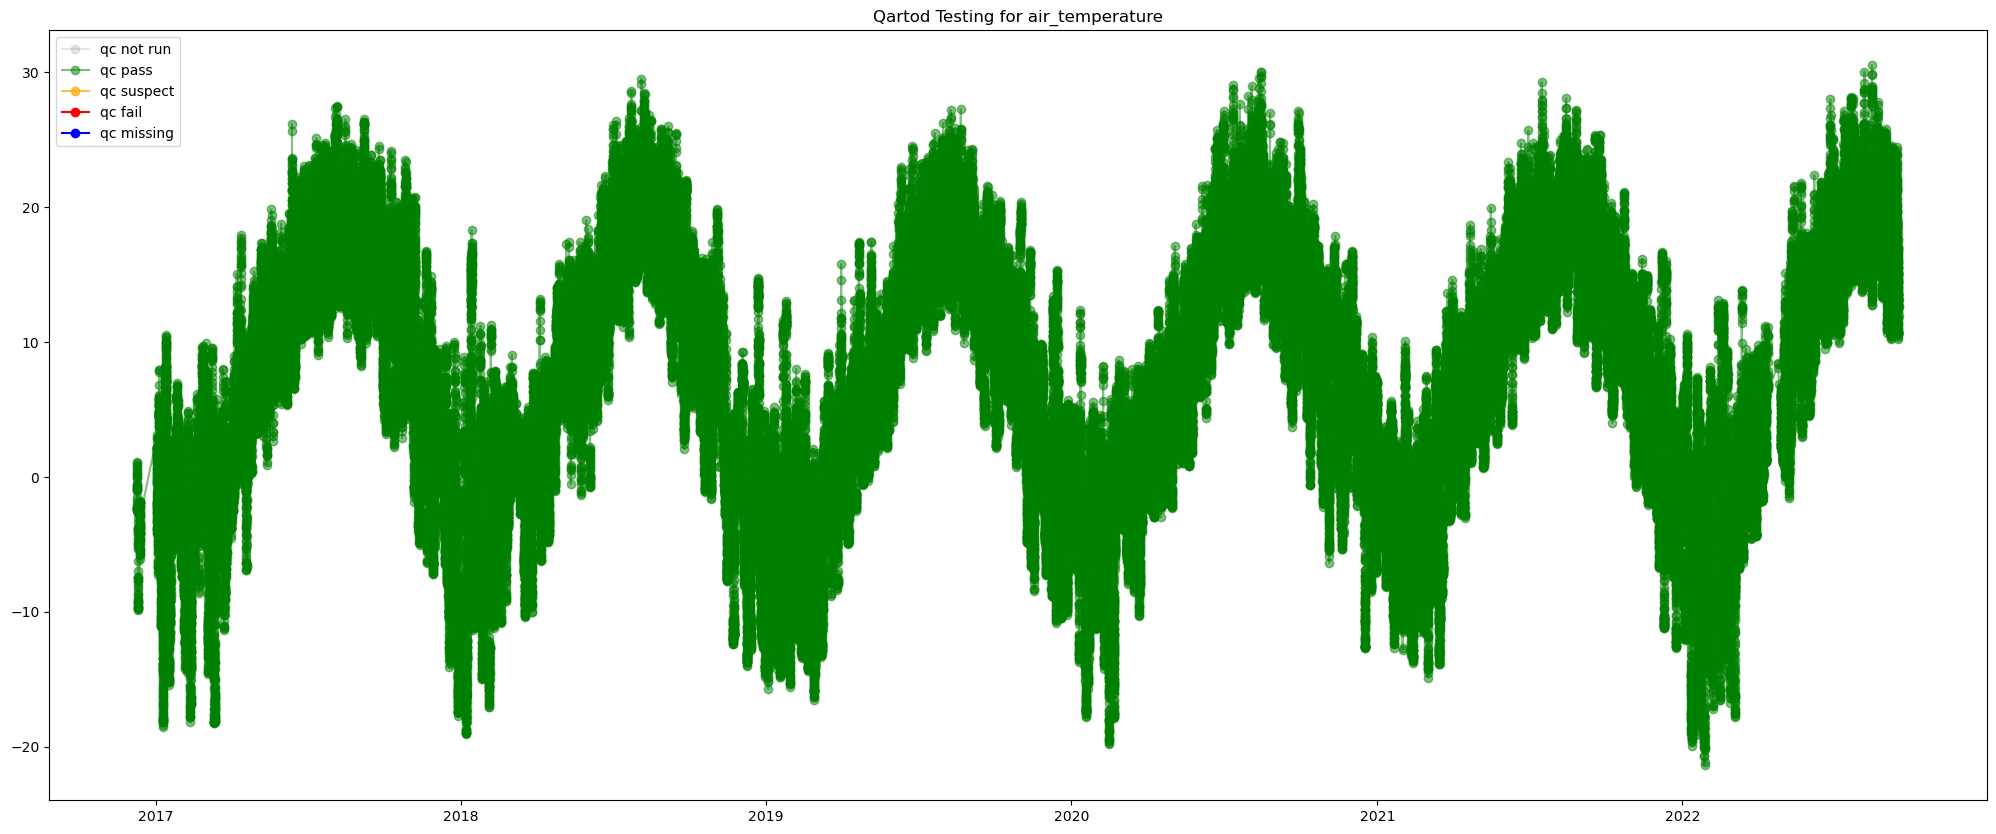

[1 1 1 ... 1 1 1]
[ 1.841064  1.904324  2.076027 ... 15.50502  16.41324  17.06163 ]


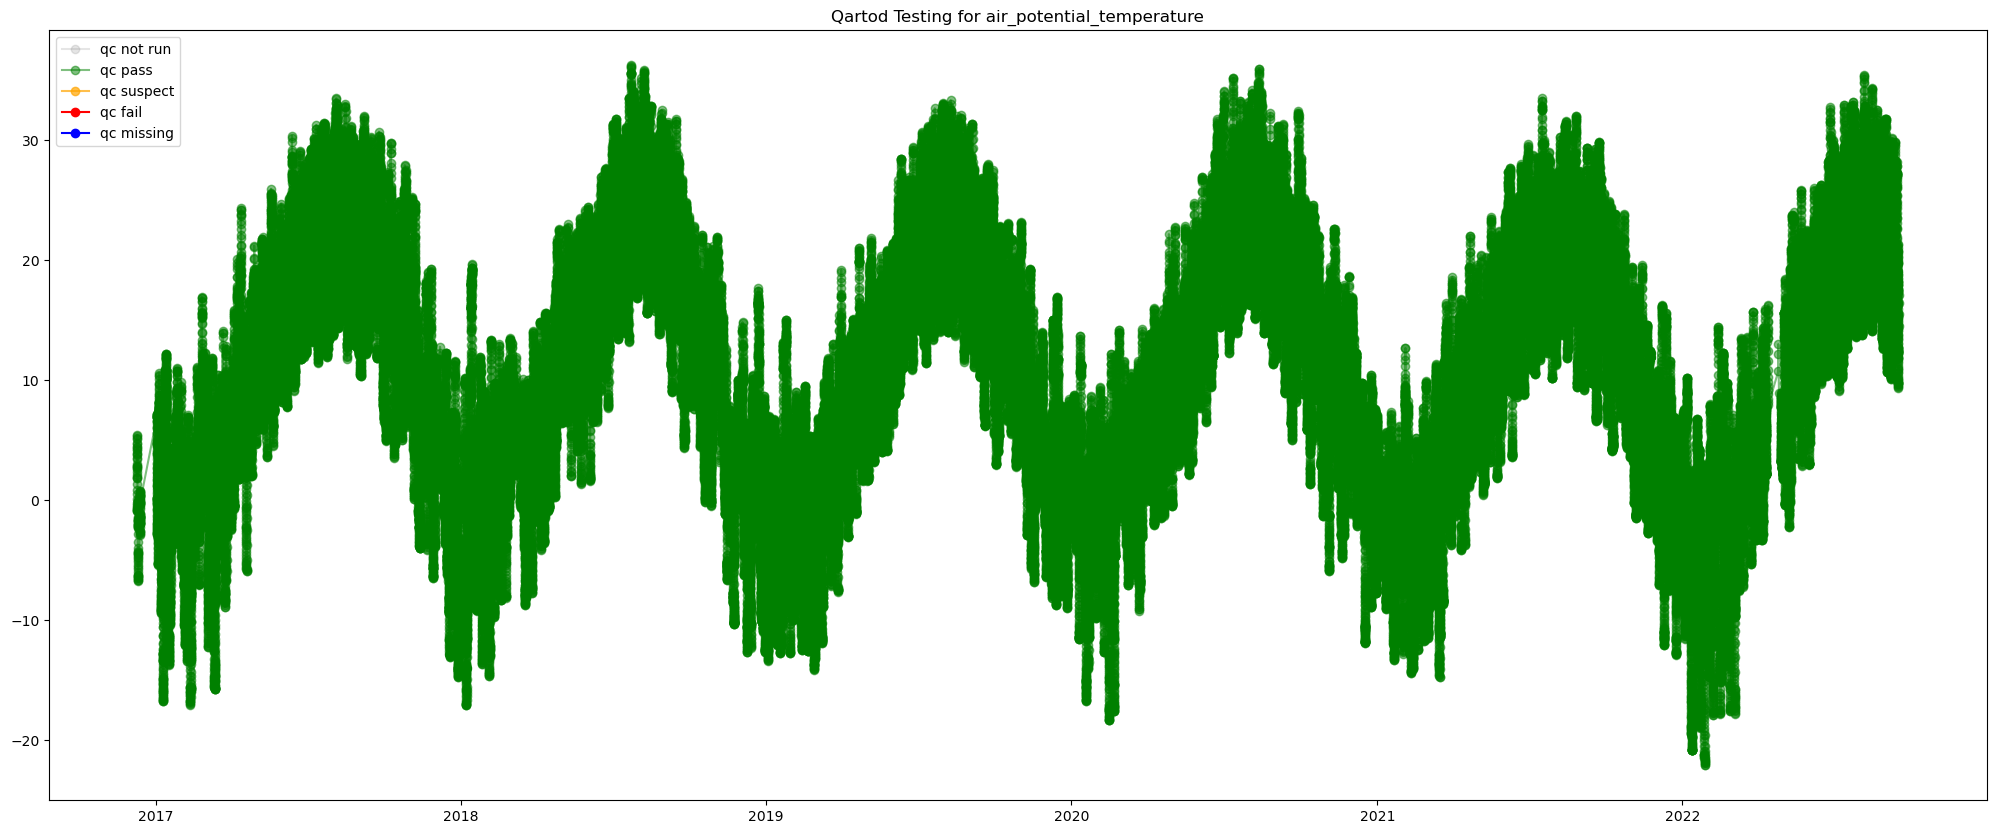

[1 1 1 ... 1 1 1]
[0.1047368 0.2717377 0.1954774 ... 0.50341   0.5130458 0.5737197]


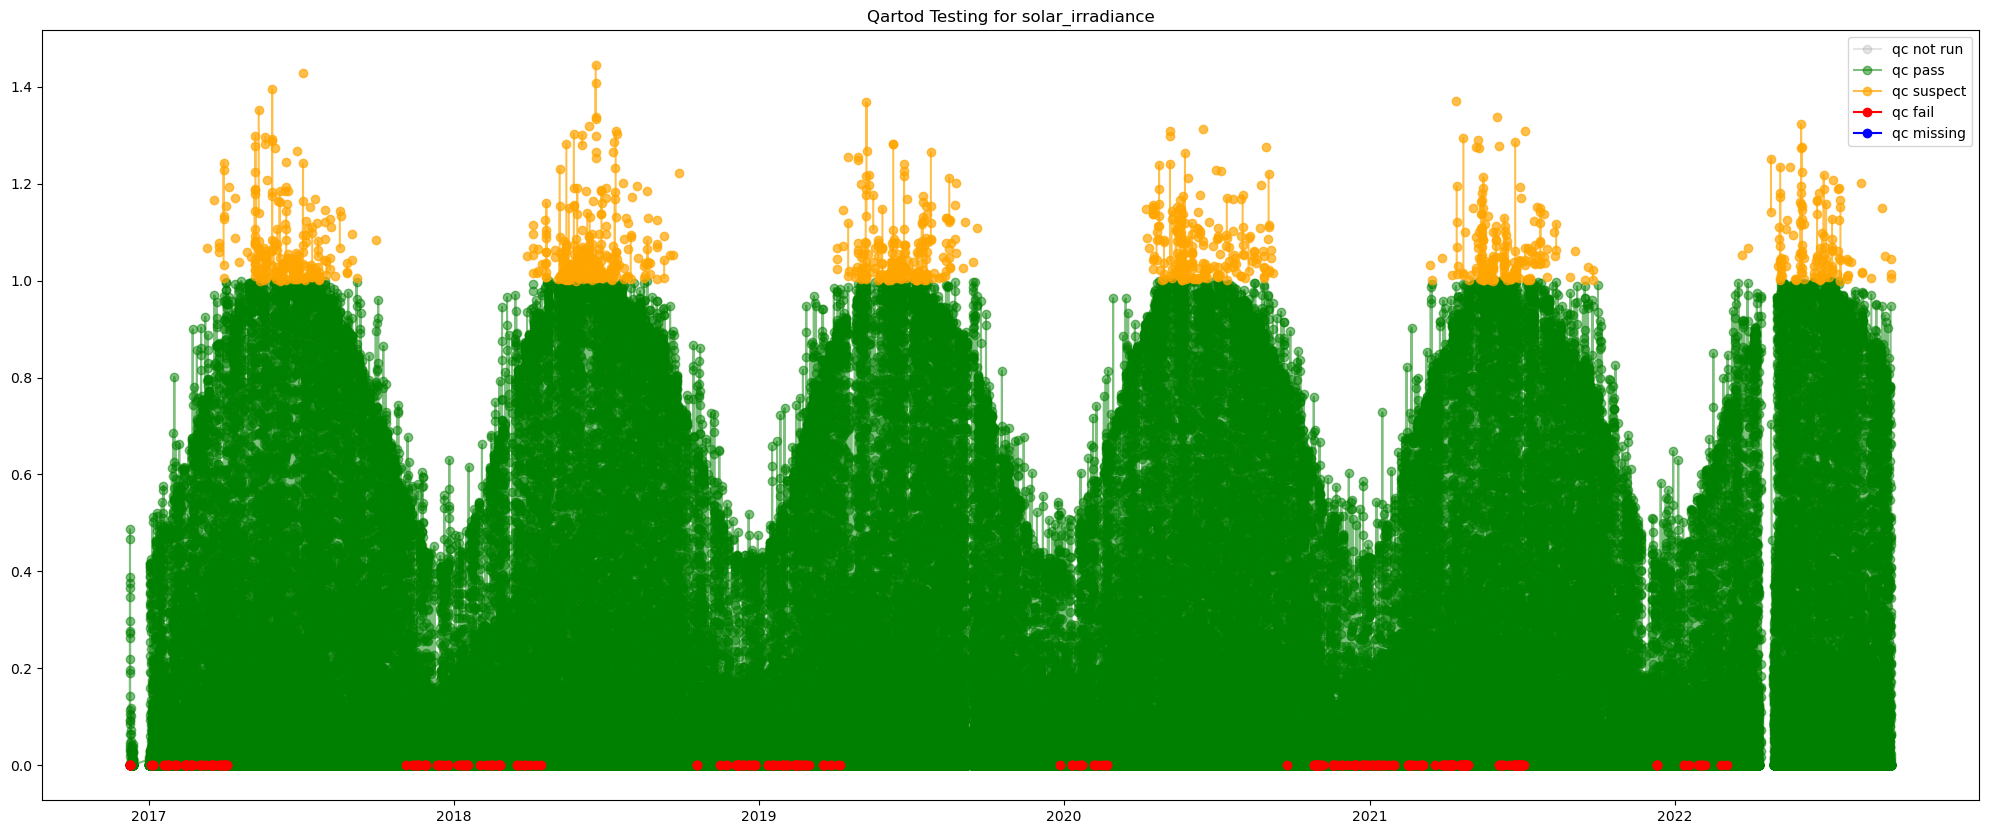

[1 1 1 ... 1 1 1]
[74.0163  70.96338 68.82634 ... 61.27178 59.50538 58.60742]


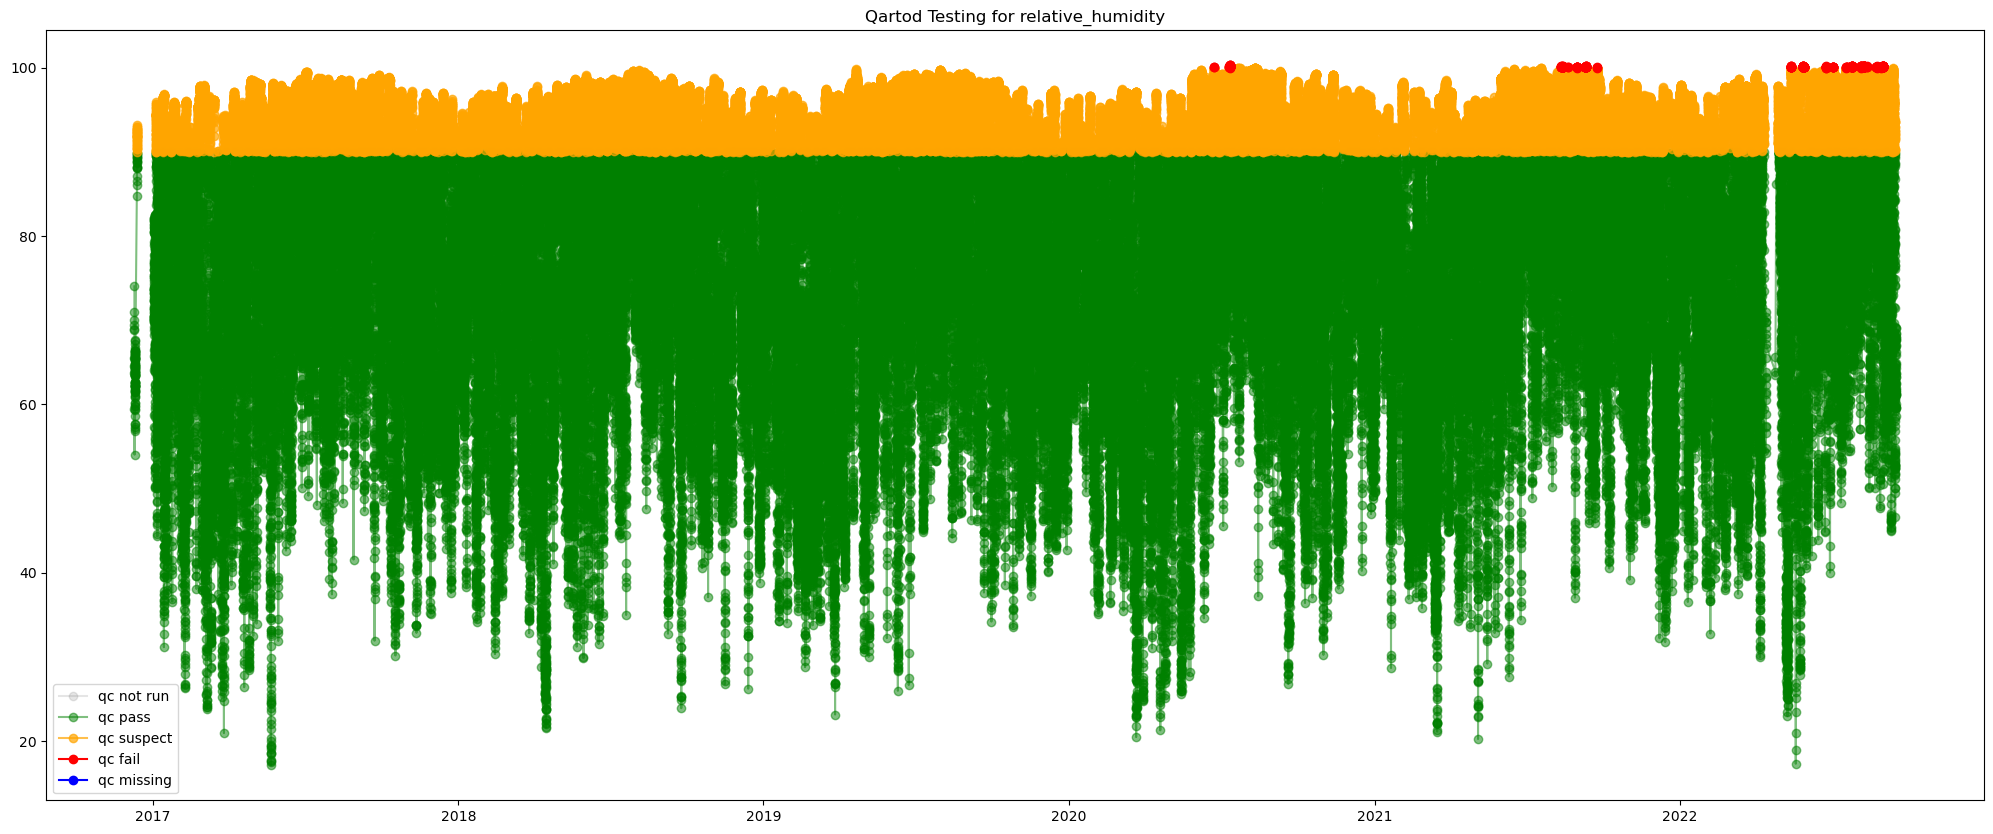

In [ ]:
## Results visualization

for test in results:
    print(test.results)
    print(test.data)
    GRAPH_TITLE = "Qartod Testing for " + test.stream_id
    VARIABLE_NAME = test.results
    matplotlib_results(df_csv, test, GRAPH_TITLE)



